In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import stats
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)

In [3]:
gndvi_img_dir = "/home/dat/Workspace/Thesis/lettuce_detector/data/raw/2017-10-27_Ortho/GNDVI/lettuce"
csv_file = "/home/dat/Workspace/Thesis/data/Spreadsheet/Lettuce/2017-10-27.csv"

### Distribution of GNDVI values

In [4]:
lettuce_gndvi = {}
for fname in os.listdir(gndvi_img_dir):
    img = np.asarray(Image.open(os.path.join(gndvi_img_dir, fname)).convert("L"))
    gndvi = (img - 128) / 128
    gndvi = (np.average(img) - 128) / 128
    lettuce_gndvi[fname.split(".")[0]] = np.average(gndvi)

In [5]:
gndvi_values = list(lettuce_gndvi.values())

print("Average: %.4f" % np.average(gndvi_values))
print("Std Dev: %.4f" % np.std(gndvi_values))

Average: 0.0157
Std Dev: 0.1692


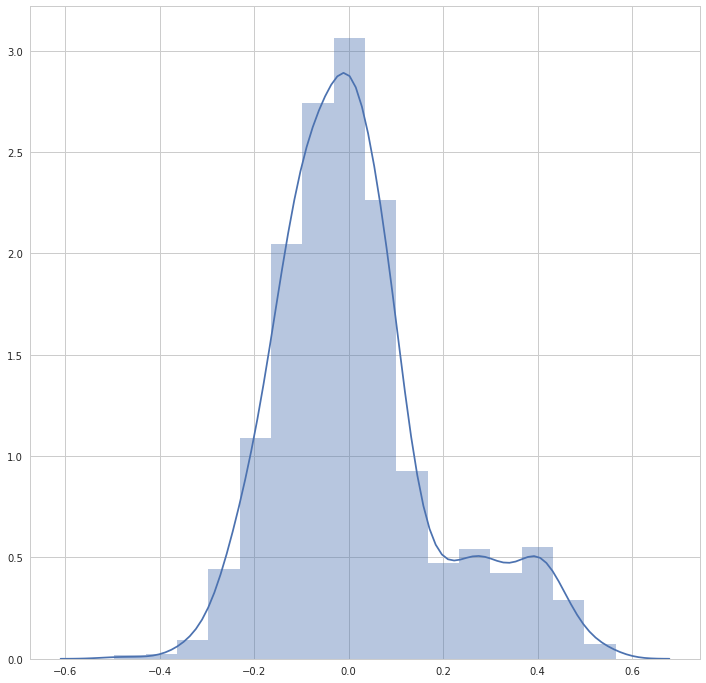

In [6]:
sns.distplot(gndvi_values, bins=16)

In [7]:
nitrogen_gndvi = {}
irrigation_gndvi = {}
for treatment in [100, 50, 25, 0]:
    nitrogen_gndvi[treatment] = []
    irrigation_gndvi[treatment] = []
    for k, v in lettuce_gndvi.items():
        if "N{}".format(treatment) in k:
            nitrogen_gndvi[treatment].append(v)
        if "IR{}".format(treatment) in k:
            irrigation_gndvi[treatment].append(v)

In [8]:
nitrogen_avg = {k:np.average(values) for k, values in nitrogen_gndvi.items()}
nitrogen_stddev = {k:np.std(values) for k, values in nitrogen_gndvi.items()}

print(nitrogen_avg)
print(nitrogen_stddev)

{100: 0.032958274272962981, 50: -0.029517637364824129, 25: -0.02634901493632261, 0: 0.083582331058943082}
{100: 0.17731483148780056, 50: 0.111383539462535, 25: 0.11523061145891478, 0: 0.21886652236785362}


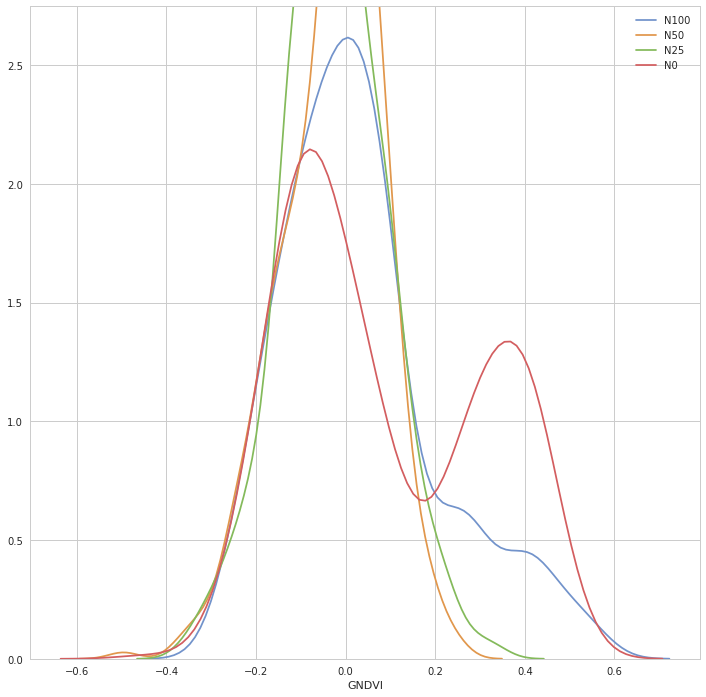

In [9]:
sns.distplot(nitrogen_gndvi[100], bins=16, hist=False, color="#7293CB", label="N100")
sns.distplot(nitrogen_gndvi[50],  bins=16, hist=False, color="#E1974C", label="N50")
sns.distplot(nitrogen_gndvi[25],  bins=16, hist=False, color="#84BA5B", label="N25")
sns.distplot(nitrogen_gndvi[0],   bins=16, hist=False, color="#D35E60", label="N0", axlabel="GNDVI")

In [10]:
irrigation_avg = {k:np.average(values) for k, values in irrigation_gndvi.items()}
irrigation_stddev = {k:np.std(values) for k, values in irrigation_gndvi.items()}

print(irrigation_avg)
print(irrigation_stddev)

{100: 0.059643635033448571, 50: 0.0044934272657557667, 25: 0.03451896137363266, 0: -0.035697980714908734}
{100: 0.17328370372388716, 50: 0.15313557001840367, 25: 0.16686987053487182, 0: 0.16824697494986438}


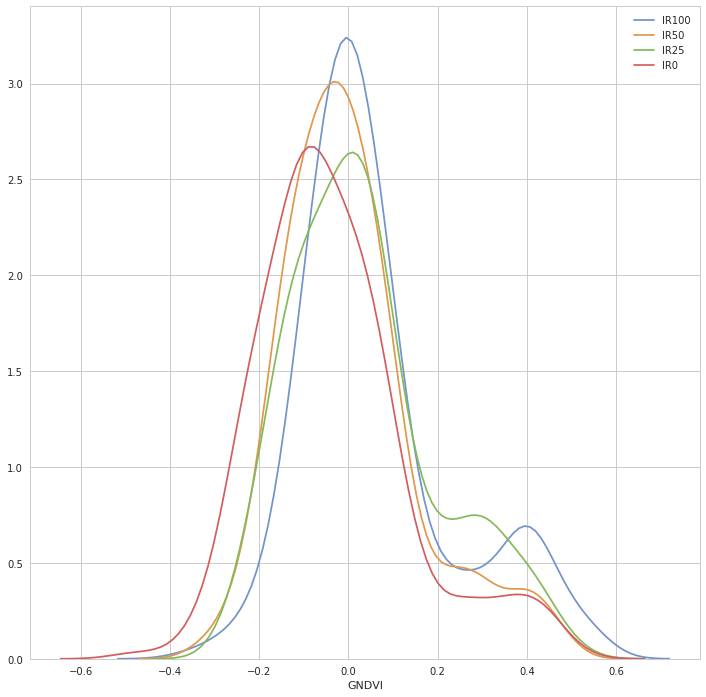

In [11]:
sns.distplot(irrigation_gndvi[100], bins=16, hist=False, color="#7293CB", label="IR100")
sns.distplot(irrigation_gndvi[50],  bins=16, hist=False, color="#E1974C", label="IR50")
sns.distplot(irrigation_gndvi[25],  bins=16, hist=False, color="#84BA5B", label="IR25")
sns.distplot(irrigation_gndvi[0],   bins=16, hist=False, color="#D35E60", label="IR0", axlabel="GNDVI")

### Analyze ground data

In [12]:
df = pd.read_csv(csv_file)
df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count
0,0,0,1,104,48.9,0.805878,-4.80,6,7
1,0,0,1,113,44.4,0.815393,NaN,6,7
2,0,0,2,104,48.8,0.839747,-4.24,4,6
3,0,0,2,113,53.5,0.819832,NaN,4,6
4,0,0,3,104,51.9,0.812323,-4.82,7,6


In [13]:
pre_df = {
    "Nitrogen": [],
    "Irrigation": [],
    "Replication": [],
    "Plant Number": [],
    "uav_gndvi": [],
}
for k, v in lettuce_gndvi.items():
    nitrogen = int(re.search("N(.*)IR.*", k).group(1))
    irrigation = int(re.search(".*IR(.*)Rep.*", k).group(1))
    replication = int(re.search(".*Rep(.*)_", k).group(1))
    number = int(re.search(".*_(.*)", k).group(1))
    
    if number == 104 or number == 113:
        pre_df["Nitrogen"].append(nitrogen)
        pre_df["Irrigation"].append(irrigation)
        pre_df["Replication"].append(replication)
        pre_df["Plant Number"].append(number)
        pre_df["uav_gndvi"].append(v)

gndvi_df = pd.DataFrame(data=pre_df)

In [14]:
merged_df = pd.merge(df, gndvi_df, on=["Nitrogen", "Irrigation", "Replication", "Plant Number"])
merged_df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count,uav_gndvi
0,0,0,1,104,48.9,0.805878,-4.80,6,7,-0.169618
1,0,0,1,113,44.4,0.815393,NaN,6,7,-0.094130
2,0,0,2,104,48.8,0.839747,-4.24,4,6,-0.192787
3,0,0,2,113,53.5,0.819832,NaN,4,6,-0.065605
4,0,0,3,104,51.9,0.812323,-4.82,7,6,0.259055


In [15]:
print("UAV GNDVI & Chlorophyll:", stats.pearsonr(merged_df["uav_gndvi"], merged_df["Chlorophyll"])[0])
print("UAV GNDVI & NDVI:", stats.pearsonr(merged_df["uav_gndvi"], merged_df["NDVI"])[0])
print("UAV GNDVI & Height:", stats.pearsonr(merged_df["uav_gndvi"], merged_df["Average Height"])[0])
print("UAV GNDVI & Leaf Count:", stats.pearsonr(merged_df["uav_gndvi"], merged_df["Average Leaf Count"])[0])
print("UAV GNDVI & WP:", stats.pearsonr(merged_df.dropna()["uav_gndvi"], merged_df.dropna()["WP"])[0])


UAV GNDVI & Chlorophyll: 0.201583258689
UAV GNDVI & NDVI: 0.0246447377112
UAV GNDVI & Height: 0.171364102539
UAV GNDVI & Leaf Count: 0.00714053457929
UAV GNDVI & WP: 0.290493781477
UAV GNDVI & Irrigation: 0.220820020944
UAV GNDVI & Nitrogen: -0.0151839101347


In [18]:
# Drop data of area with broken irrigation
df = df[(df.Nitrogen != 25) | (df.Irrigation != 0) | (df.Replication != 3)]

In [19]:
print("UAV GNDVI & Irrigation:", stats.pearsonr(merged_df["uav_gndvi"], merged_df["Irrigation"])[0])
print("UAV GNDVI & Nitrogen:", stats.pearsonr(merged_df["uav_gndvi"], merged_df["Nitrogen"])[0])

UAV GNDVI & Irrigation: 0.220820020944
UAV GNDVI & Nitrogen: -0.0151839101347


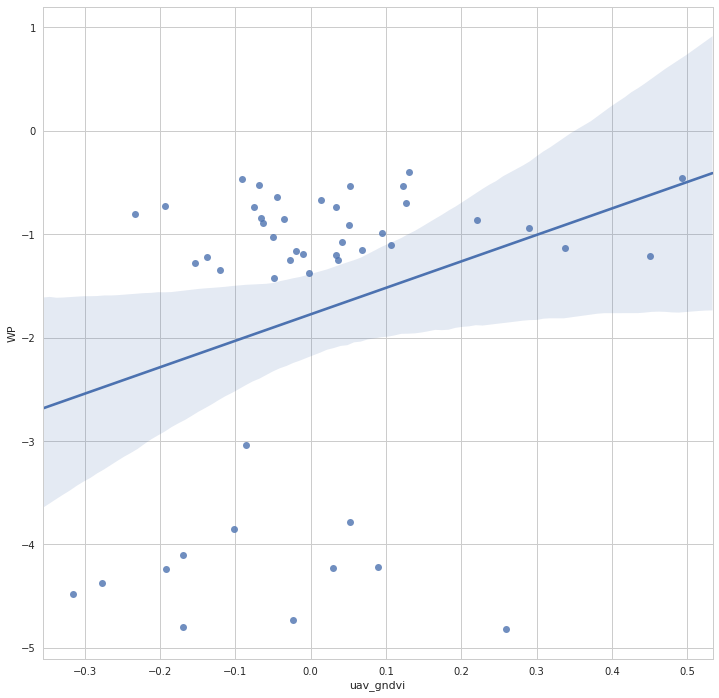

In [16]:
sns.regplot(x=merged_df["uav_gndvi"], y=merged_df["WP"])

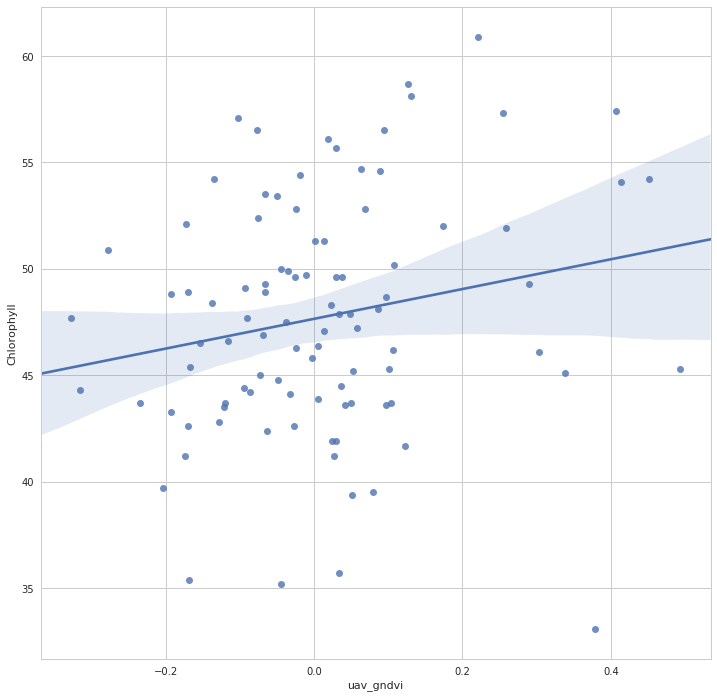

In [17]:
sns.regplot(x=merged_df["uav_gndvi"], y=merged_df["Chlorophyll"])